In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('../')
from unsplit.unsplit.models import MLP, CNN

In [3]:
import os
import torch
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

def set_device(device_no: int):
    if torch.cuda.is_available():
        device = torch.device(f"cuda:{device_no}")
        print("There are %d GPU(s) available." % torch.cuda.device_count())
        print("We will use the GPU:", torch.cuda.get_device_name(device_no))
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")
        
    return device

In [4]:
device = set_device(0)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080 Ti


In [7]:
import unsplit.unsplit.attacks as attacks
from unsplit.unsplit.util import *
from models import *
from tqdm.auto import tqdm

In [8]:
dataset_name = "cifar10"
architecture = "mlp-mixer"
batch_size = 64

n_epochs = 10
split_layer = 1

In [9]:
def create_models_and_data(dataset_name="mnist", architecture="mlp", device=None, seed=0):
    assert dataset_name in ["mnist", "f_mnist", "cifar10"], "Wrong dataset name. Valid options are 'mnist', 'f_mnist' and 'cifar10'."
    assert architecture in ["mlp", "cnn", "mlp-mixer"], "Wrong architecture name. Valid options are 'mlp', 'cnn' and 'mlp-mixer'."
    dataset_creator = datasets.MNIST if dataset_name == "mnist" else datasets.FashionMNIST \
        if dataset_name == "f_mnist" else datasets.CIFAR10
    model_creator = MLP if architecture == "mlp" else CNN if architecture == "cnn" else MLPMixer

    trainset = dataset_creator(f'data/{dataset_name}', download=True, train=True, transform=transforms.ToTensor())
    testset = dataset_creator(f'data/{dataset_name}', download=True, train=False, transform=transforms.ToTensor())

    torch.manual_seed(seed)
    client, server = model_creator().to(device), model_creator().to(device)
    return client, server, trainset, testset

In [10]:
client, server, trainset, testset = create_models_and_data(dataset_name=dataset_name,
                                                           architecture=architecture,
                                                           device=device)

assert next(client.parameters()).is_cuda == True
assert next(server.parameters()).is_cuda == True

Files already downloaded and verified
Files already downloaded and verified


In [11]:
def train_client_server(client, server, trainset, testset, split_layer, n_epochs, device, batch_size=64):
    trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=batch_size)

    client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
    server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        running_loss = 0
        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)
            client_opt.zero_grad()
            server_opt.zero_grad()

            client_pred = client(images, end=split_layer)
            pred = server(client_pred, start=split_layer+1)

            loss = criterion(pred, labels)
            loss.backward()
            running_loss += loss

            server_opt.step()
            client_opt.step()
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_acc(client, server, testloader, split=split_layer)}')
    return client, server

In [12]:
client, server = train_client_server(client=client, server=server, trainset=trainset, testset=testset, 
                                     split_layer=split_layer, n_epochs=10, device=device, batch_size=64)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Loss: 1.939502239227295 Acc: 0.33629998564720154


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Loss: 1.6890348196029663 Acc: 0.3837999999523163


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Loss: 1.556063175201416 Acc: 0.45509999990463257


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Loss: 1.4806573390960693 Acc: 0.4596000015735626


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Loss: 1.417551040649414 Acc: 0.44589999318122864


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Loss: 1.3611961603164673 Acc: 0.5126000046730042


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Loss: 1.3188097476959229 Acc: 0.5414000153541565


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Loss: 1.2767170667648315 Acc: 0.5329999923706055


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Loss: 1.2524436712265015 Acc: 0.5482000112533569


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Loss: 1.2162270545959473 Acc: 0.5590999722480774


In [13]:
COUNT = 1
inversion_targets = [get_examples_by_class(testset, i, count=COUNT).to(device) for i in range(10)]

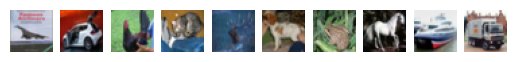

In [18]:
display_cifar(inversion_targets)

In [19]:
main_iters, input_iters, model_iters = 200, 20, 20
lambda_l2, lambda_tv = 0.1, 1.0

In [25]:
def launch_attack(inversion_targets, client, split_layer, clone_architecture="mlp",
                  main_iters=1000, input_iters=100, model_iters=100,
                  lambda_tv=0.1, lambda_l2=1, device="cuda:0"):
    assert clone_architecture in ["mlp", "cnn", "mlp-mixer"], "Wrong architecture name. Valid options are 'mlp' and 'cnn'."
    clone = MLP() if architecture == "mlp" else CNN() if architecture == "cnn" else MLPMixer()
    mse = torch.nn.MSELoss()
    
    reconstructed_images, reconstruction_losses = [], []
    cut_layer_training_losses = []
    for idx, target in enumerate(inversion_targets):
        # obtain client output
        with torch.no_grad():
            client_out = client(target, end=split_layer)

        # perform the attack
        target_size = target.size()
        reconstructed, cur_loss_arr = attacks.model_inversion_stealing(
            clone, split_layer, client_out, target_size,
            main_iters=main_iters, input_iters=input_iters, model_iters=model_iters, 
            lambda_tv=lambda_tv, lambda_l2=lambda_l2, device=device
        )
        cut_layer_training_losses.append(cur_loss_arr)

        # save result
        reconstructed = normalize(reconstructed)
        reconstructed_images.append(reconstructed)
        reconstruction_loss = mse(reconstructed, target)
        reconstruction_losses.append(reconstruction_loss.item())
    return clone, reconstructed_images, reconstruction_losses, cut_layer_training_losses

In [26]:
clone, reconstructed_images, reconstruction_losses, cut_layer_training_losses = launch_attack(
    inversion_targets, client, split_layer, clone_architecture=architecture,
    main_iters=main_iters, input_iters=input_iters, model_iters=model_iters,
    lambda_tv=lambda_tv, lambda_l2=lambda_l2, device=device
)

100%|██████████| 200/200 [00:10<00:00, 18.26it/s]


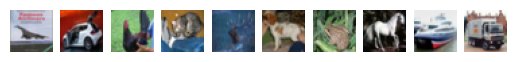

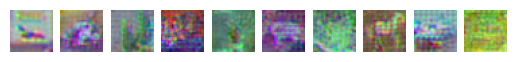

In [27]:
display_cifar(inversion_targets)
display_cifar(reconstructed_images)

In [28]:
def compute_metrics(inversion_targets, reconstructed_images, 
                    reconstruction_losses, cut_layer_training_losses,
                    compute_fid=False):
    reconstruction_mse = np.mean(reconstruction_losses)
    cut_layer_mse = np.mean([loss_arr[-1] for loss_arr in cut_layer_training_losses])
    print(f"Recounstruction MSE: {reconstruction_mse:.3f}")
    print(f"Log10 of cut layer MSE: {np.log10(cut_layer_mse):.3f}")
    if compute_fid:
        print(f"FID: {compute_fid(inversion_targets, reconstructed_images):.1f}")

In [29]:
compute_metrics(inversion_targets, reconstructed_images, reconstruction_losses, cut_layer_training_losses)

Recounstruction MSE: 0.050
Log10 of cut layer MSE: -3.135


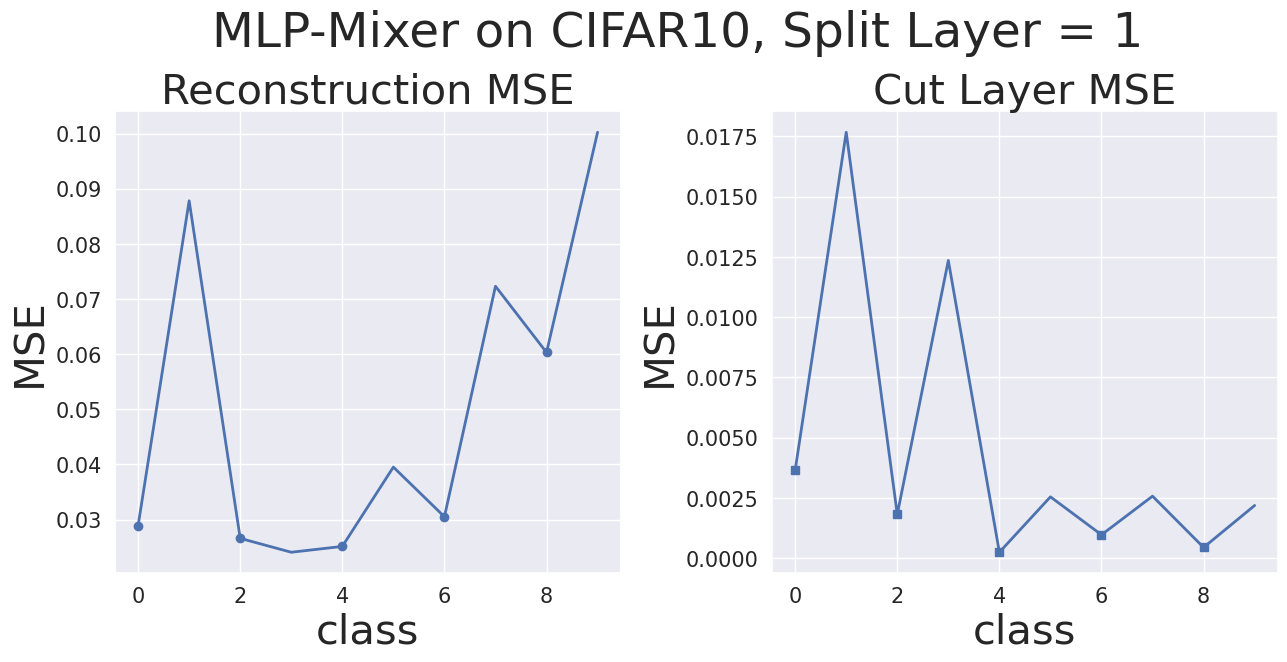

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
cut_layer_mse = np.mean(cut_layer_training_losses, axis=1)
markers = ['o','s']
titles = [f'Reconstruction MSE',  f'Cut Layer MSE']
data = [reconstruction_losses, cut_layer_mse]

for i, axis in enumerate(ax):
    axis.plot(data[i], linewidth=2, marker=markers[i], markersize=6, markevery=2)
    axis.set_xlabel('class', fontsize=30)
    axis.set_ylabel('MSE', fontsize=30)
    axis.set_title(titles[i], fontsize=30)
    axis.grid(True)
    axis.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.3)
plt.suptitle('MLP-Mixer on CIFAR10, Split Layer = {}'.format(split_layer), fontsize=35, y=1.05)
plt.show()

**No Training**

In [31]:
wo_train_client, wo_train_server, trainset, testset = create_models_and_data(dataset_name=dataset_name,
                                                           architecture=architecture,
                                                           device=device,
                                                           seed=42,
                                                           )

assert next(wo_train_client.parameters()).is_cuda == True
assert next(wo_train_server.parameters()).is_cuda == True

Files already downloaded and verified
Files already downloaded and verified


In [32]:
wo_train_clone, wo_train_reconstructed_images, wo_train_reconstruction_losses, wo_train_cut_layer_training_losses = launch_attack(
    inversion_targets, wo_train_client, split_layer, clone_architecture=architecture,
    main_iters=main_iters, input_iters=input_iters, model_iters=model_iters,
    lambda_tv=lambda_tv, lambda_l2=lambda_l2, device=device
)

100%|██████████| 200/200 [00:11<00:00, 17.59it/s]


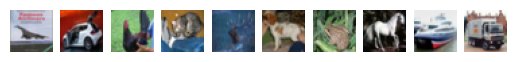

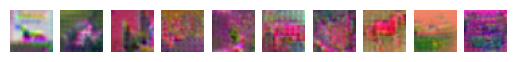

In [33]:
display_cifar(inversion_targets)
display_cifar(wo_train_reconstructed_images)

In [34]:
compute_metrics(inversion_targets, wo_train_reconstructed_images, wo_train_reconstruction_losses, wo_train_cut_layer_training_losses)

Recounstruction MSE: 0.059
Log10 of cut layer MSE: -3.116


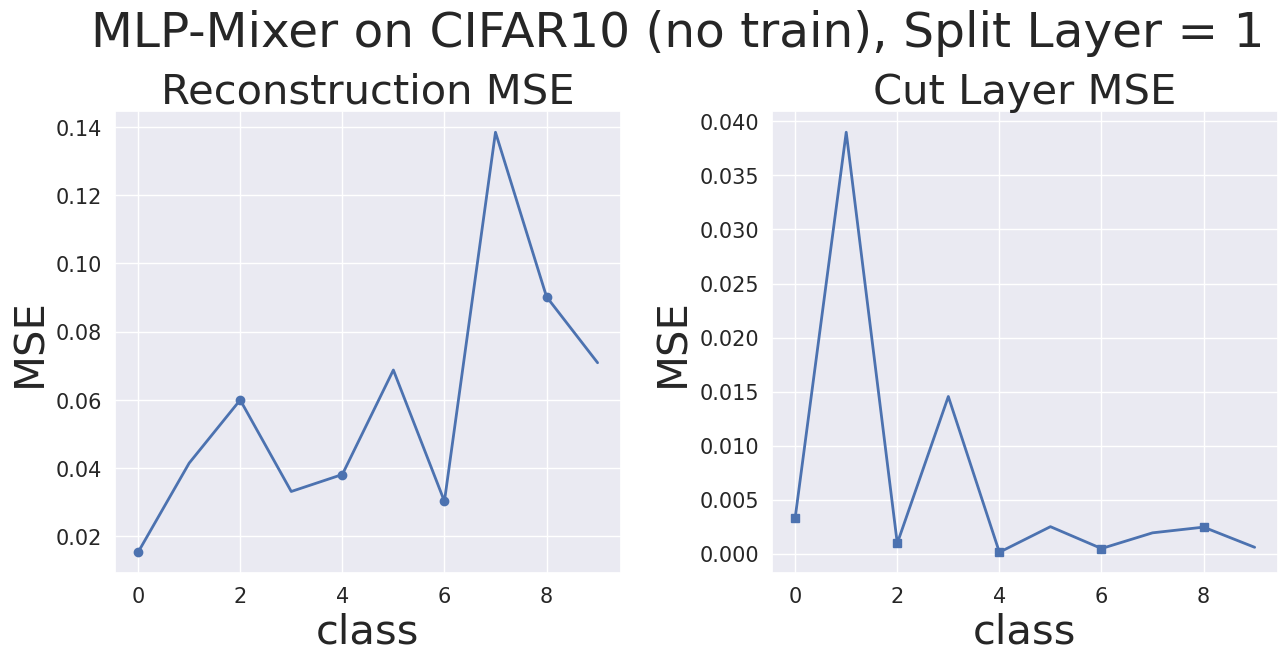

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
cut_layer_mse = np.mean(wo_train_cut_layer_training_losses, axis=1)
markers = ['o','s']
titles = [f'Reconstruction MSE',  f'Cut Layer MSE']
data = [wo_train_reconstruction_losses, cut_layer_mse]

for i, axis in enumerate(ax):
    axis.plot(data[i], linewidth=2, marker=markers[i], markersize=6, markevery=2)
    axis.set_xlabel('class', fontsize=30)
    axis.set_ylabel('MSE', fontsize=30)
    axis.set_title(titles[i], fontsize=30)
    axis.grid(True)
    axis.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.3)
plt.suptitle('MLP-Mixer on CIFAR10 (no train), Split Layer = {}'.format(split_layer), fontsize=35, y=1.05)
plt.show()